In [1]:
%matplotlib inline
from pylab import *
import cv2

In [2]:
rcParams['figure.figsize'] = 10, 10

In [3]:
from dataset import load_image

In [4]:
import torch

In [5]:
torch.cuda.empty_cache()

In [6]:
from utils import cuda

In [7]:
from generate_masks import get_model

In [8]:
from albumentations import Compose, Normalize

In [9]:
from albumentations.torch.functional import img_to_tensor

In [10]:
def img_transform(p=1):
    return Compose([
        Normalize(p=1)
    ], p=p)

In [11]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [12]:
model_path = 'runs/debug/model.pt'
model = get_model(model_path, model_type='AlbuNet')

In [27]:
from prepare_train_val import get_split

In [28]:
a, b = get_split()

In [13]:
img_file_name = '/home/raznem/proj_kaggle_airbus/data/train_v2/000155de5.jpg'
gt_file_name = '/home/raznem/proj_kaggle_airbus/data/binary_masks/000155de5.jpg'

In [14]:
image = load_image(img_file_name)
gt = cv2.imread(gt_file_name, 0) > 0

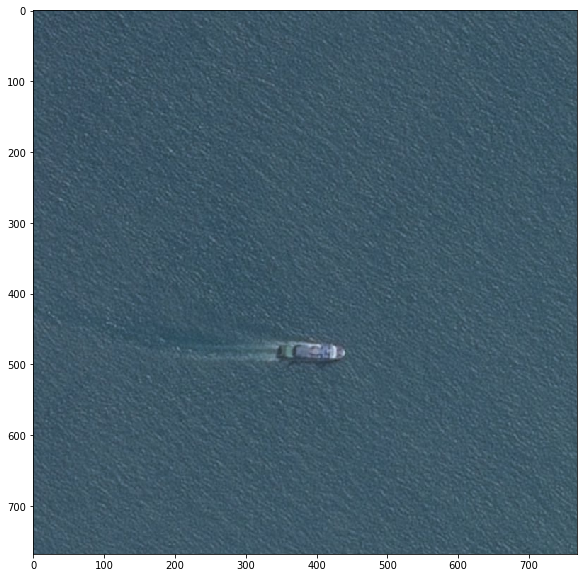

In [15]:
imshow(image)

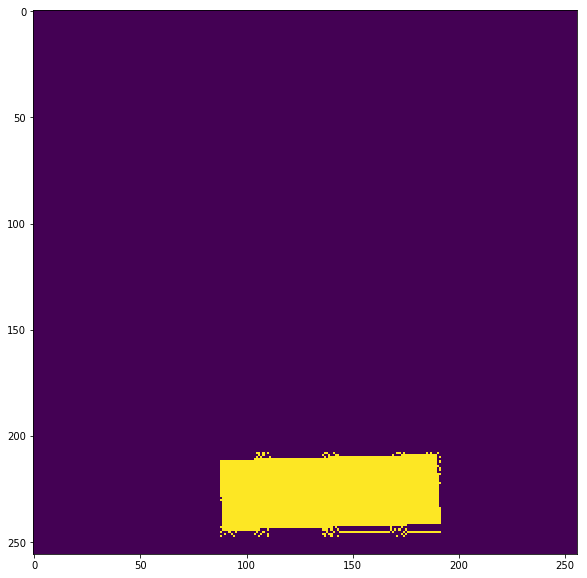

In [40]:
imshow(gt)

In [17]:
with torch.no_grad():
    input_image = torch.unsqueeze(img_to_tensor(img_transform(p=1)(image=image)['image']).cuda(), dim=0)

In [18]:
mask = model(input_image)

/home/agaidash/anastasiia/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [19]:
mask_array = mask.data[0].cpu().numpy()[0]

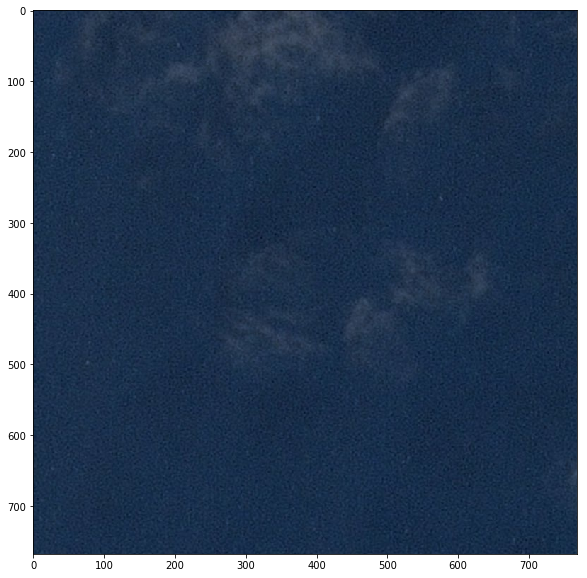

In [32]:
imshow(mask_overlay(image, (mask_array > 0).astype(np.uint8)))